In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from timeit import timeit
from scipy.spatial.distance import cdist
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
def rbf_kernel(t):
    return np.exp( - 1/2 * t**2  )

In [257]:
def make_poly_pred_(x, y, anchor, weights, degree):
    # Transform the data and the regression anchor into the correct basis
    x_ = PolynomialFeatures(degree).fit_transform(x)
    anchor_ = PolynomialFeatures(degree).fit_transform(anchor.reshape(1, -1))
    # Fit the weighted linear regression model on the data
    model = LinearRegression().fit(x_, y, sample_weight = weights)
    
    # Predict at the regression anchor
    y_hat = model.predict(anchor_).item()
    
    return y_hat

In [258]:
def compute_robust_weights_(y, y_hat):
    residuals = y - y_hat
    s = np.median(np.abs(residuals))
    robust_weights = np.clip(residuals / (6.0 * s), -1, 1)
    return (1 - robust_weights ** 2) ** 2

In [259]:
def fit_loess(x, y, anchors = None, degree = 2, kernel = rbf_kernel, alpha = 1, frac = None, robust_iters = 1):
    assert degree >= 0 and isinstance(degree, int), 'robust_iters must be a non-negative integer'
    
    if frac is not None:
        assert  0 < frac < 1, 'frac must be in (0, 1)'
        
    assert robust_iters > 0 and isinstance(robust_iters, int), 'robust_iters must be a positive integer'
    
    # Ensure arrays are 2-dimensional
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    
    # If we don't supply regression anchors, set every point to be one
    if anchors is None:
        anchors = x
    elif len(anchors.shape) == 1:
        anchors = anchors.reshape(-1, 1)
    
    # Compute euclidean distances between each regression anchor and the rest of the data
    dists = cdist(anchors, x, 'euclidean')   
    
    # Initialise robust weights as ones
    robust_weights = np.ones(anchors.shape[0])
    
    # Array to hold predictions for the regression anchors
    y_hat = np.zeros(anchors.shape[0])
    if frac is None:
        # Compute the weights using all of the distances 
        weights = kernel( dists / alpha )
        
        for robust_iteration in range(robust_iters):
            # For each regression anchor, ignore (approximately) zero weights and predict
            for i in range(anchors.shape[0]):
                idcs = np.where(robust_weights * weights[i, :] > 1e-10)[0]
                y_hat[i] = make_poly_pred_(x[idcs, :], y[idcs],
                                           anchors[i, :], weights[i, idcs],
                                           degree)
            
            # Stop after appropriate number of iterations
            if (robust_iteration + 1) != robust_iters:
                compute_robust_weights_ = robust_weights_(y, y_hat)

    else:
        # Compute the fraction to take
        m = int(frac * n)

        # Get the indices for the sorted distances
        frac_idcs = np.argsort(dists, axis = 1)[:, :m]
        
        for robust_iteration in range(robust_iters):
            # For each regression anchor, compute the sorted weights and predict
            for i in range(anchors.shape[0]):
                idcs = frac_idcs[i, :]
                weights = robust_weights[idcs] * kernel( dists[i, idcs] / alpha )
                y_hat[i] = make_poly_pred_(x[idcs, :], y[idcs],
                                           anchors[i, :], weights,
                                           degree)
            
            # Stop after appropriate number of iterations
            if (robust_iteration + 1) != robust_iters:
                compute_robust_weights_ = robust_weights_(y, y_hat)

    return y_hat

# One-dimensional Example

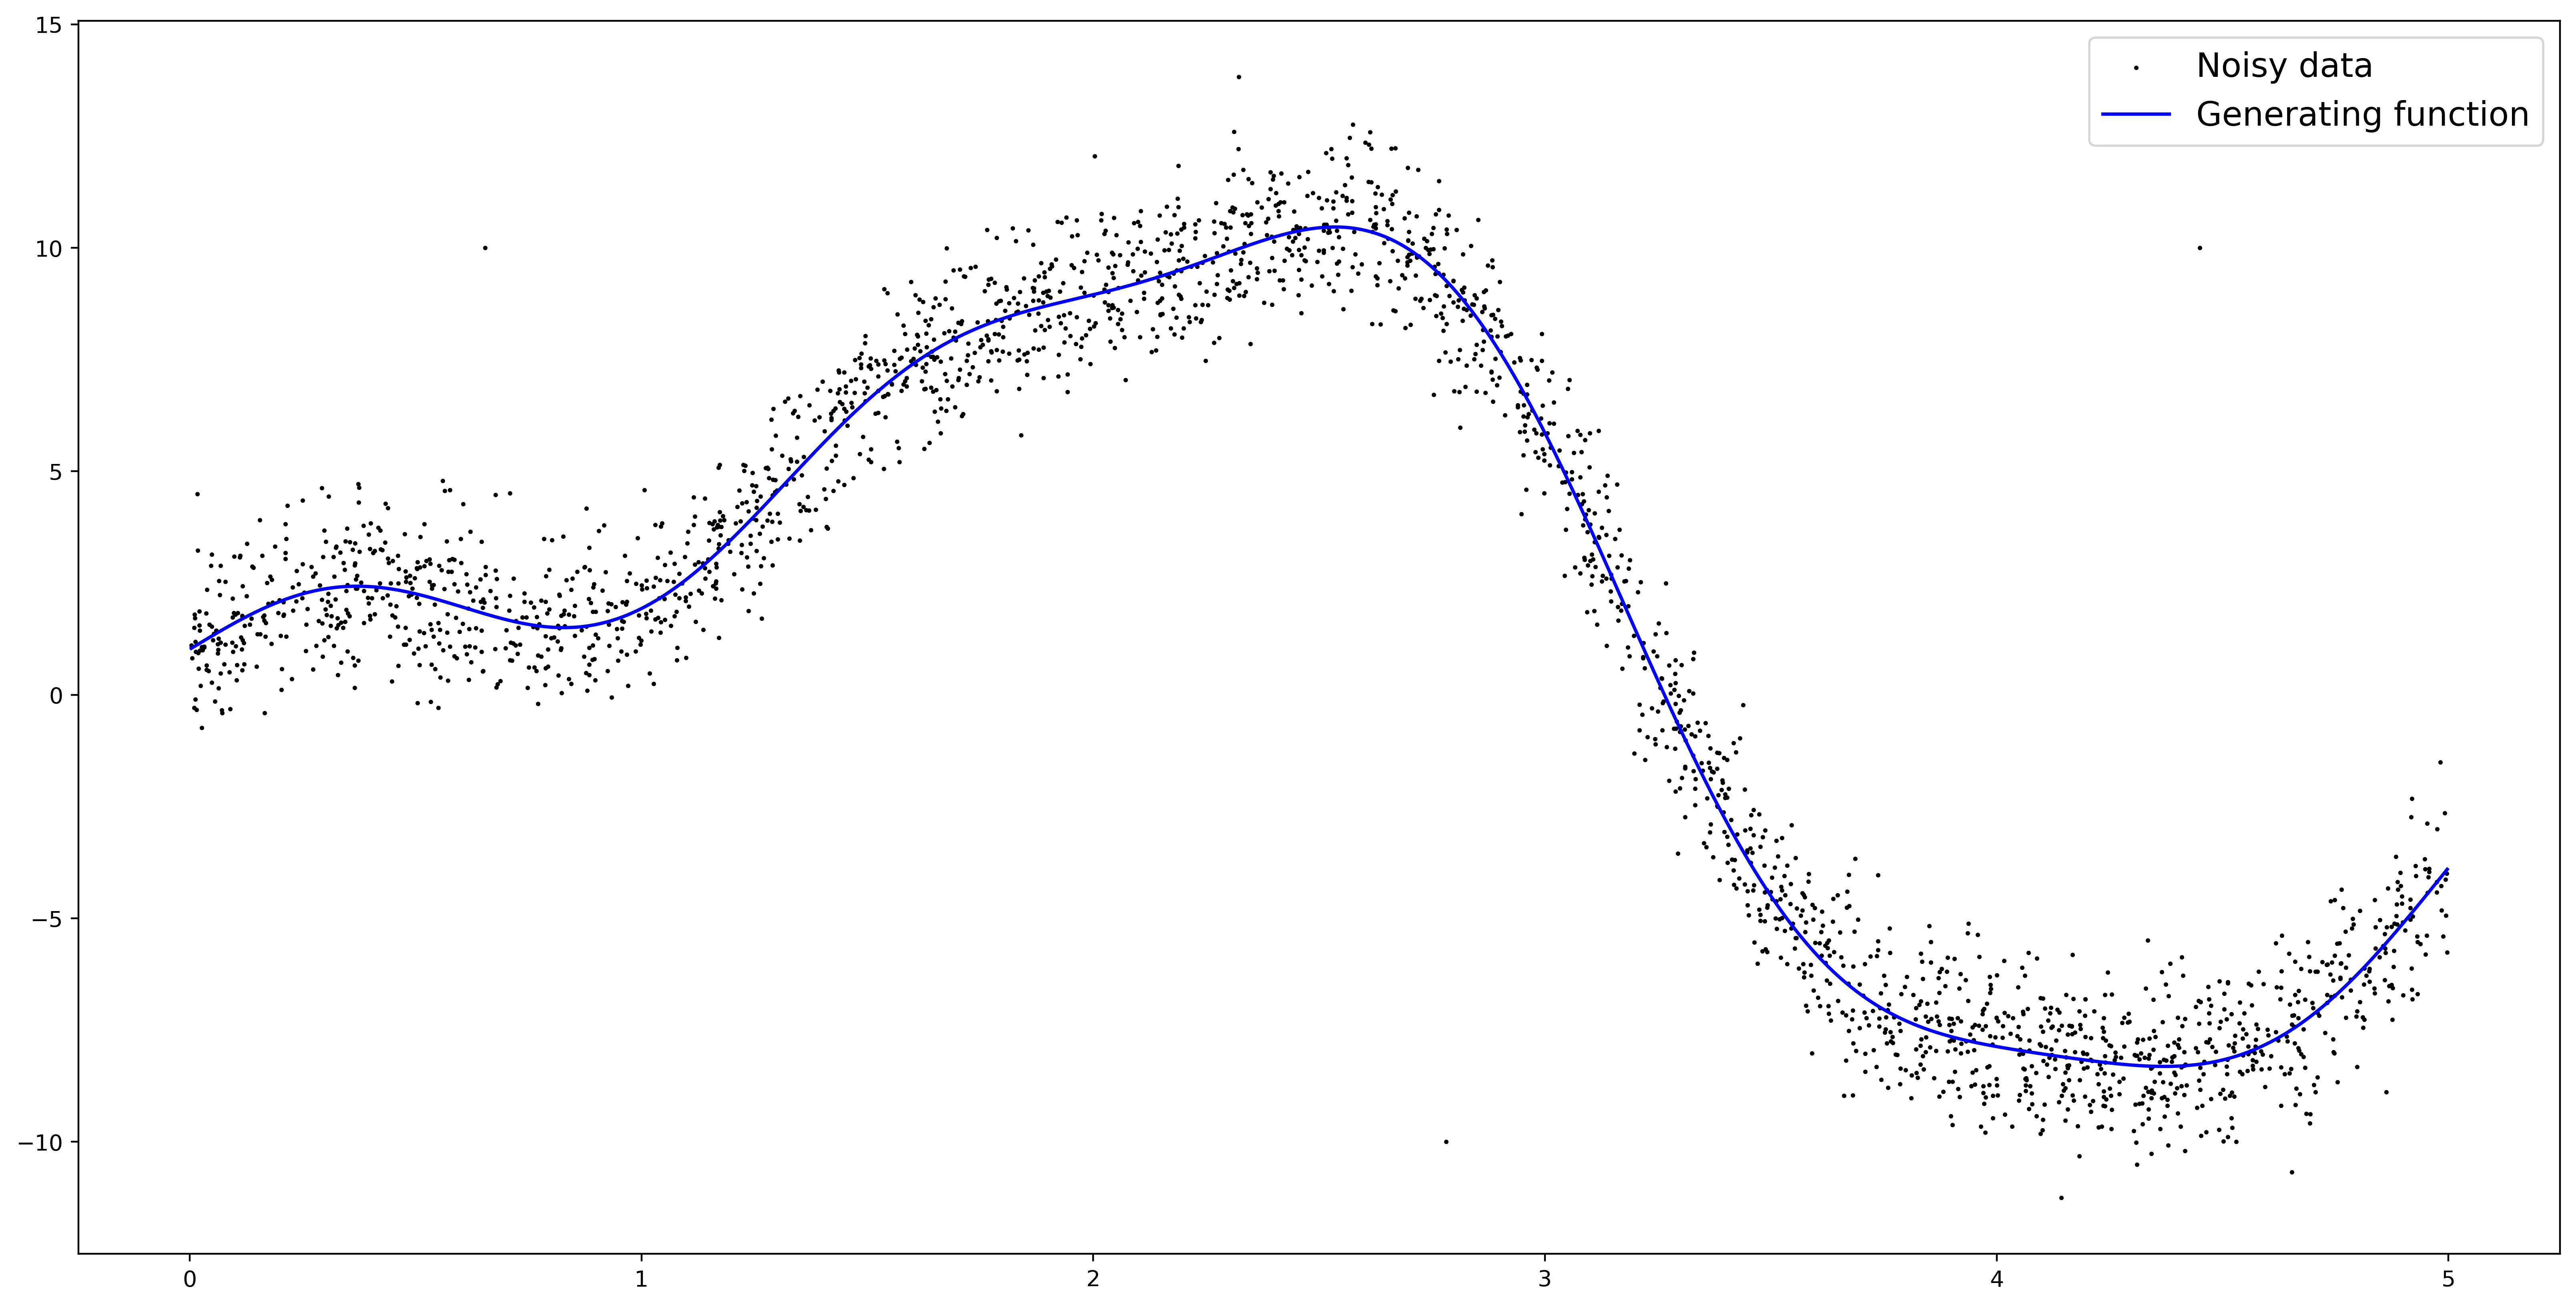

In [271]:
n = 2500

x = np.random.uniform(0, 5, n)
eps = np.random.normal(0, 1, n)
generating = np.sin(x) + np.sin(5*x) + np.cos(1/10 * x) + 10*np.exp(- (x - 2.5)**2 ) - 10*np.exp(- (x - 4)**2 )
y = generating + eps

# Add some outliers
y[100] = 10
y[150] = -10
y[200] = 10

plt.figure(figsize = (20, 10), dpi = 400)
plt.scatter(x, y, s = 1, color = 'black', label = 'Noisy data', alpha = 1)
out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')
plt.legend(fontsize = 15)
plt.show()

In [261]:
( ( y - generating ) **2 ).mean()

1.137727856357553

In [262]:
y_hat0 = fit_loess(x, y, anchors = None, degree = 0, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 4)
y_hat1 = fit_loess(x, y, anchors = None, degree = 1, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 4)
y_hat2 = fit_loess(x, y, anchors = None, degree = 2, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 4)
#y_hat3 = fit_loess(x, y, anchors = None, degree = 3, kernel = rbf_kernel, alpha = 0.15, frac = None, robust_iters = 0)

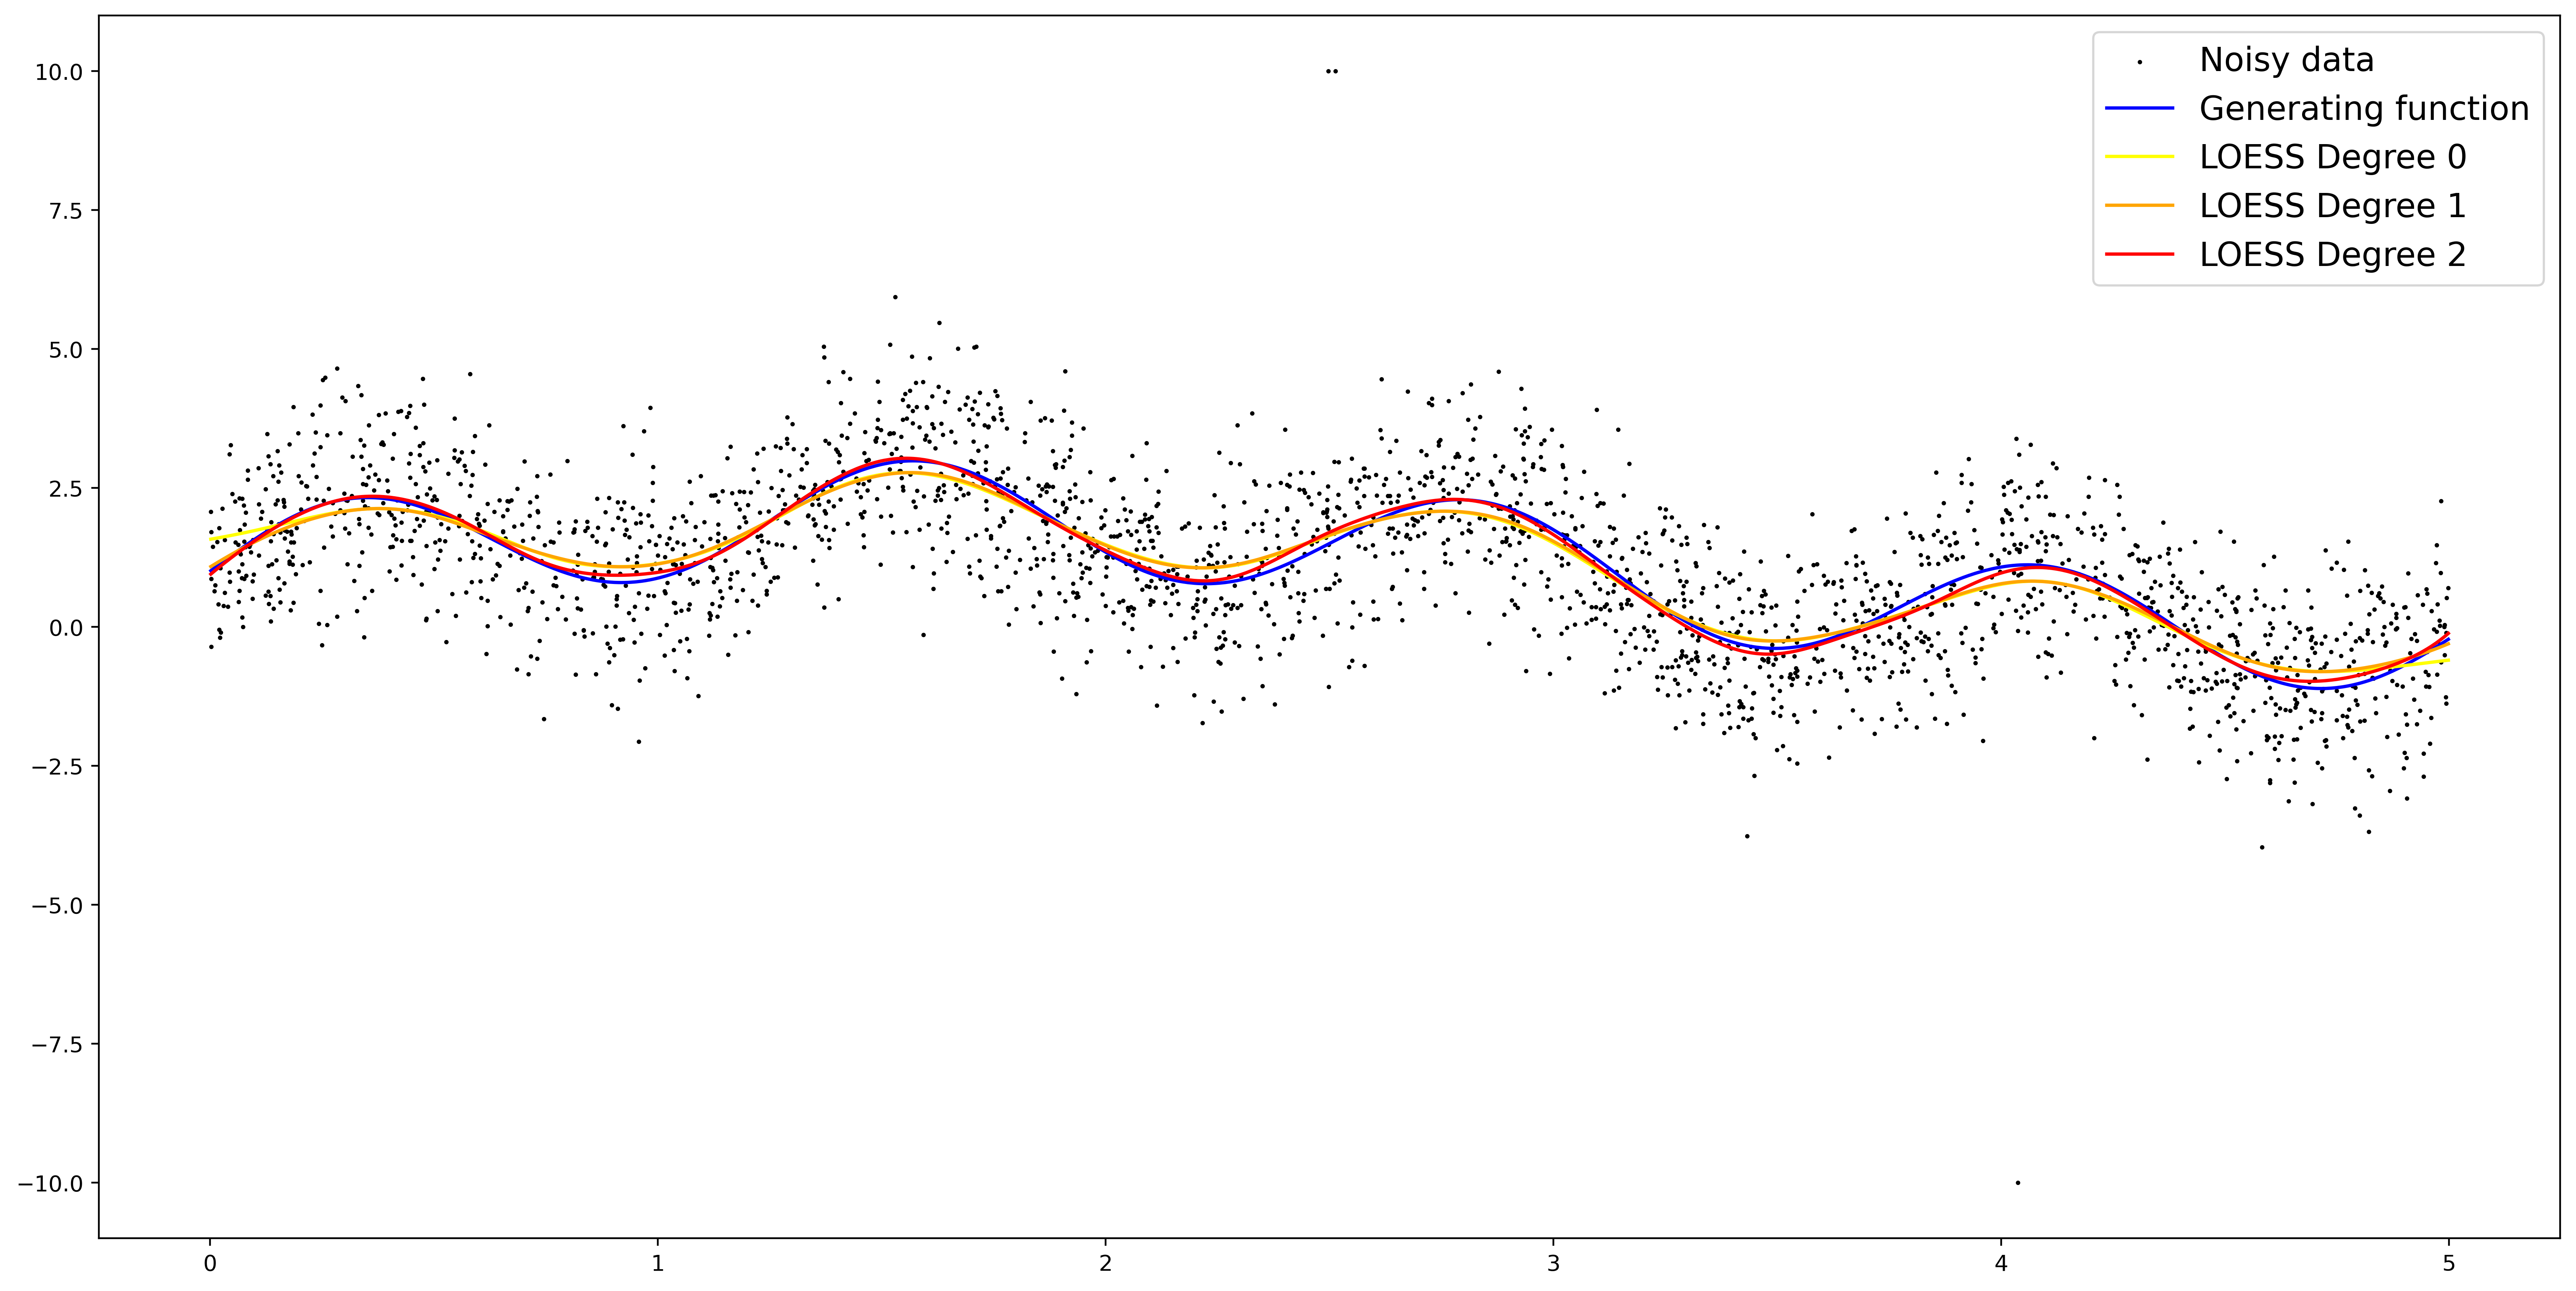

In [263]:
anchors = x

plt.figure(figsize = (20, 10), dpi = 400)
plt.scatter(x, y, s = 1, color = 'black', label = 'Noisy data', alpha = 1)

out = np.hstack((x.reshape(-1, 1), generating.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'blue', label = 'Generating function')

out = np.hstack((anchors.reshape(-1, 1), y_hat0.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'yellow', label = 'LOESS Degree 0')

out = np.hstack((anchors.reshape(-1, 1), y_hat1.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'orange', label = 'LOESS Degree 1')

out = np.hstack((anchors.reshape(-1, 1), y_hat2.reshape(-1, 1)))
out = out[np.argsort(out[:, 0]), :]
plt.plot(out[:, 0], out[:, 1], color = 'red', label = 'LOESS Degree 2')

#out = np.hstack((anchors.reshape(-1, 1), y_hat3.reshape(-1, 1)))
#out = out[np.argsort(out[:, 0]), :]
#plt.plot(out[:, 0], out[:, 1], color = 'pink', label = 'LOESS Degree 3')

plt.legend(fontsize = 15)
plt.show()


In [264]:
( ( y - y_hat0 ) **2 ).mean()

1.1641613884935744

In [265]:
( ( y - y_hat1 ) **2 ).mean()

1.1582929964648228

In [266]:
( ( y - y_hat2 ) **2 ).mean()

1.127035211666688

In [267]:
( ( y - y_hat3 ) **2 ).mean()

ValueError: operands could not be broadcast together with shapes (2500,) (1000,) 

# Two-dimensional Example

In [45]:
n = 10000

x = np.random.rand(n, 2)

def f(x,y):
    return np.cos( 2 * np.pi * x ) * ( 1 - 3*np.sin(y) )

eps = np.random.normal(0, 0.1, n)
y = f(x[:, 0], x[:, 1]) + eps

m = np.arange(0, 1, 0.05)
anchor_x, anchor_y = np.meshgrid(m, m)
anchors = np.array([np.ravel(anchor_x), np.ravel(anchor_y)]).T

y_hat = fit_loess(x, y, anchors = anchors, degree = 2, kernel = rbf_kernel, alpha = 1, frac = 0.15)
y_hat = y_hat.reshape(anchor_x.shape)

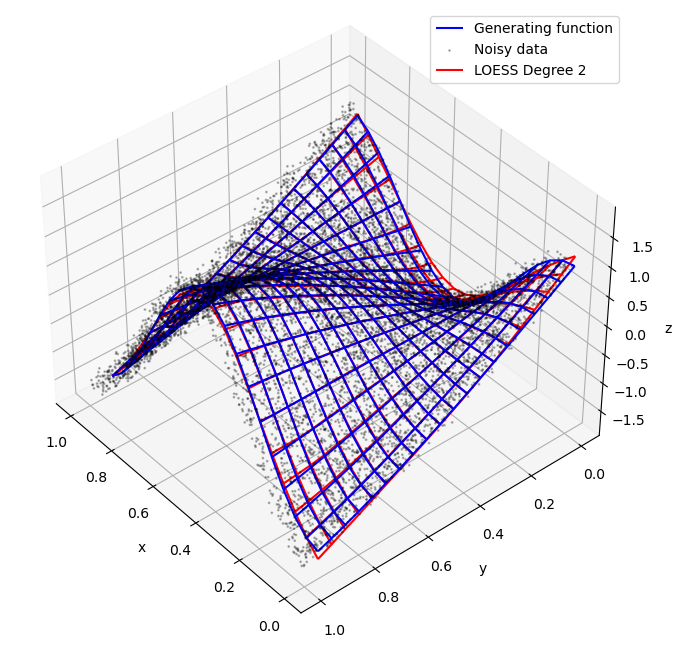

In [46]:
fig = plt.figure(figsize = (25, 8))
ax = fig.add_subplot(111, projection = '3d')

generating = f(anchor_x, anchor_y)
generating = generating.reshape(anchor_x.shape)
ax.plot_wireframe(anchor_x, anchor_y, generating, rcount = 20, ccount = 20, color = 'blue', label = 'Generating function')
ax.scatter(x[:,0], x[:,1], y, '.', color = 'black', alpha = 0.25, label = 'Noisy data', s = 1)
ax.plot_wireframe(anchor_x, anchor_y, y_hat, rcount = 20, ccount = 20, color = 'red', label = 'LOESS Degree 2')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.legend()

ax.view_init(40, 140)